# Parameter Estimation in Bayesian Networks

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d5/Hey_Machine_Learning_Logo.png" width="400px" height="400px" />

> Throughout this point we have assumed that we already have a graphical model (both, the structure and parameters) as an input. But, as you may suspect by now, this is not the case in real-life problems.
>
> One way to obtain a graphical model is to elicit both the network and the parameters by hand with the help of an expert. This is a nontrivial task (recall the knowledge engineering section you read), and may require a lot of work (weeks or even months, depending on the size of the network). Moreover, the access to an expert can be a non plausible assumption.
>
> On the other hand, it is common to have access to a set of examples generated from the distribution (process) we want to model. Hence, in this class and in the following, we will focus on constructing a model from a set of data instances: **model learning**.

> **Objetives:**
> - To describe the problem of model learning.
> - To derive the maximum likelihood  parameter estimators for Bayesian Networks.
> - To derive the maximum aposteriori parameter estimators for Bayesian Networks.

> **References:**
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Ch. 17.
> - Mastering Probabilistic Graphical Models Using Python, By Ankur Ankan and Abinash Panda. Ch. 5.
> - Probabilistic Graphical Models Specialization, offered through Coursera. Prof. Daphne Koller.


<p style="text-align:right;"> Imagen recuperada de: https://upload.wikimedia.org/wikipedia/commons/d/d5/Hey_Machine_Learning_Logo.png.</p>

___

# 1. Learning overview

The complete process of learning can be summarized in the following diagram:

In [59]:
from IPython.display import Image

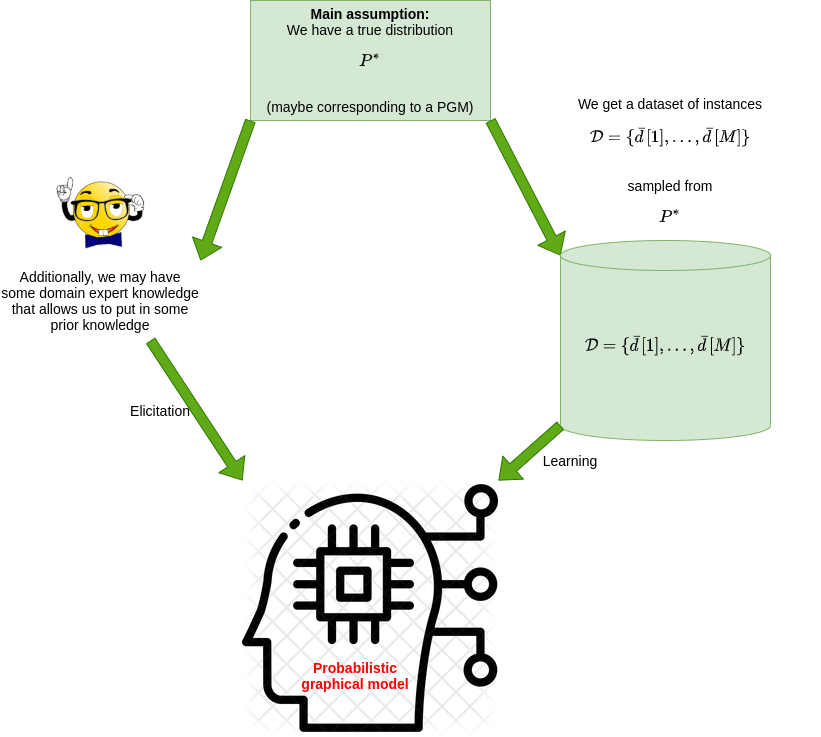

In [60]:
Image("figures/pgm_construction.png")

## 1.1. Why would we want to learn a probabilistic graphical model?

### 1. To answer general probabilistic queries about new instances.

What will we optimize? **The training set likelihood**

$$P(\mathcal{D} : \mathcal{M}).$$

- If a model makes the data more likely, then it was more likely to have generated this data set.
  
However, what we really care about is *new data*, not the data that we have seen before.

- So, we evaluate the model on a separate test set: **Test set likelihood**
  
  $$P(\mathcal{D}' : \mathcal{M}).$$

### 2. To perform a specific prediction task on new instances.

In this setting, we want to predict target variables $\bar{y}$ from some observed variables $\bar{x}$.

What will we optimize? An specialized objective **recall, balanced accuracy, ...**

- However, from a mathematical and algorithmical point of view, it is convenient to optimize the training set likelihood
  
  $$P(\mathcal{D} : \mathcal{M}) = \prod_{m} P(\bar{d}[m] : \mathcal{M}),$$
  
  or the conditional likelihood
  
  $$\prod_{m} P(\bar{y}[m] | \bar{x}[m] : \mathcal{M}).$$
  
Finally, the model should be evaluated over the **test set** and the **true specialized objective**.

### 3. To discover some underlying knowledge about $\mathcal{M}^*$.

In this case, we would like to:

- Distinguish between direct and indirect dependencies (edges).
- Learn the directionality of the edges.
  
What will we optimize? **The training set likelihood**

- Very convenient from a mathematical and algorithmical point of view.
- Poor representative for structural accuracy.

The model should be evaluated by comparing to prior knowledge.

## 1.2. How do we deal with overfitting?

1. If we select $\mathcal{M}$ optimizing according training set likelihood, then it will overfit to statistical noise.

2. Parameter overfitting:
   - The parameters fit to random noise in training data.
   - Solution: use regularization, or equivalently, parameter priors.

3. Structural overfitting:
   - Training likelihood always benefits more complex structures.
   - Solution: penalize model complexity.

## 1.3. Why learning a PGM?

1. Can incorporate prior knowledge into the model.

2. Learn one model, use it for what you want.

3. Framework for knowledge discovery and validation.

___
# 2. Maximum likelihood parameter estimation in BNs

We begin with a short introduction to maximum likelihood estimation (MLE), since it is the **key building block for parameter estimation**.

## 2.1. Maximum likelihood estimation

Consider the a simple biased coin, which follows a Bernoulli distribution:

- Random variable $X$ with $\mathrm{Val}(X)=\{x^0,x^1\}$.

- $P(X=x^1)=\theta$ and $P(X=x^0)=1-\theta$.

Moreover, we have a set of independent and identically distributed (IID) data instances sampled from $P$:

$$\mathcal{D} = \{x[1], x[2], \dots x[M]\}$$

**IID**:
- Tosses are independent of each other.
- Tosses are sampled from the same distribution.

How can we represent IID as a PGM?

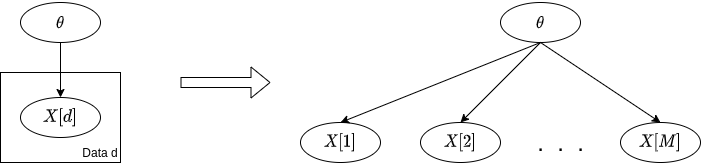

In [61]:
Image("figures/iid.png")

$$P(X[d] | \theta) = \left\{\begin{array}{ccc} \theta   & \text{if} & X[d]=x^1\\
                                               1-\theta & \text{if} & X[d]=x^0
\end{array}\right.$$

Our **goal** is to estimate the parameter $\theta \in [0, 1]$ so that the data instances $\mathcal{D} = \{x[1], x[2], \dots x[M]\}$ were likely to be predicted.

How do we evaluate the **likelihood**?

We use the likelihood of $\mathcal{D}$ given $\theta$:

$$\mathcal{L}(\theta : \mathcal{D}) = P(\mathcal{D} | \theta) = \prod_{d=1}^{M} P(x[m] | \theta),$$

because the samples are IID.

If, for example, the data instances are 

$$\mathcal{D} = \{x^1, x^0, x^1, x^1, x^0\},$$

what would the likelihood function be?

$$\mathcal{L}(\theta : \mathcal{D}) = \theta (1 - \theta) \theta \theta (1 - \theta) = \theta^3 (1 - \theta)^2.$$

In [62]:
# Import numpy
import numpy as np
# Import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
# Compute the likelihood function of the above data instances
theta = np.linspace(0, 1, 101)
L = theta**3 * (1 - theta)**2

Text(0, 0.5, '$\\mathcal{L}(\\theta: \\mathcal{D})$')

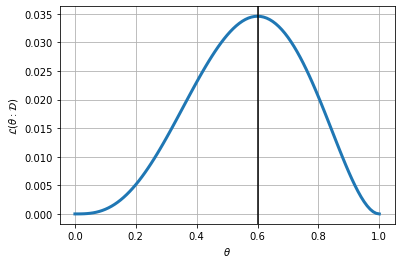

In [64]:
# Draw the likelihood function
plt.figure(figsize=(6, 4))
plt.plot(theta, L, lw=3)
plt.axvline(x=theta[L.argmax()], color='k')
plt.grid()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\mathcal{L}(\theta: \mathcal{D})$')

In [65]:
theta[L.argmax()]

0.6

What is the **optimal** value for theta?

- As intuition dictates it is ... $\frac{3}{5}=0.6$

### More generally ...

- We will have $M_1$ appearances of $x^1$ and $M_0$ appearances of $x^0$, with $M_1+M_0=M$.

- And we will find $\theta$ that maximizes the likelihood:
  
  $$\mathcal{L}(\theta:\mathcal{D})=\theta^{M_1}(1-\theta)^{M_0}.$$
  
#### Maximum likelihood estimation (MLE) principle: choose $\theta$ to maximize $\mathcal{L}(\theta:\mathcal{D})$

- Since the $\log$ is an increasing function, the above is equivalent to maximize the log-likelihood

  $$l(\theta:\mathcal{D}) = \log \mathcal{L}(\theta:\mathcal{D}) = M_1 \log(\theta) + M_0 \log(1 - \theta).$$
  
- Whose maximizer is obtained by (<font color = red>see in the whiteboard</font>):

  $$
  \begin{align}
  \frac{\partial l}{\partial \theta} = 0 \Leftrightarrow 
  &  M_1 \frac{1}{\hat{\theta}} - M_0 \frac{1}{1-\hat{\theta}} = 0 \\
  &  M_1(1-\hat{\theta}) - M_0 \hat{\theta} = 0 \\
  &  \hat{\theta} = \frac{M_1}{M_0 + M_1}
  \end{align}
  $$

Which fits very nicely with our frequentist interpretation of probability.

In [66]:
# Generate N samples from a Bernoulli distribution
M = 10
theta = 0.7
data = np.random.choice([0, 1], p=[1 - theta, theta], size=M)

In [67]:
data

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [68]:
# Estimate the parameter theta
theta_MLE = (data == 1).sum() / M
theta_MLE, theta

(0.8, 0.7)

### What happens with a multinomial?

In this case we have:

- Random variable $X$ with $\mathrm{Val}(X)=\{x^1, \dots, x^{k}\}$.

- $P(X=x^i)=\theta_i$ for $i\in\{1,\dots,k\}$.

- $\sum_{i=1}^{k}\theta_i=1$.

We assume that the data instances 

$$\mathcal{D} = \{x[1], \dots, x[M]\}$$

are such that:

- $x^1$ appears $M_1$ times,
- ...,
- $x^i$ appears $M_i$ times,
- ...,
- $x^k$ appears $M_k$ times.

with $M=\sum_{j=1}^{k}M_j$.

Thus, (**homework**) one can show that the maximum likelihood estimator (MLE) of $\theta_i$ is:

$$\hat{\theta_i} = \frac{M_i}{\sum_{j=1}^{k} M_j} = \frac{M_i}{M},$$

this is, the fraction of times $x^i$ appears in the data.

In [69]:
# Generate N samples from a multinomial distribution
M = 10
data = np.random.choice([1, 2, 3, 4], p=[0.1, 0.3, 0.4, 0.2], size=M)

In [70]:
# Estimate the parameters theta_i
theta_MLE = np.zeros(4)
for i in range(1, 5):
    theta_MLE[i - 1] = (data == i).sum() / M
    
theta_MLE

array([0.2, 0. , 0.6, 0.2])

### What happens with a Gaussian?

In this case we have:

- Random variable $X \sim \mathcal{N}(\mu, \sigma^2)$.

- $p(x;\mu,\sigma^2)=\frac{1}{\sqrt{2 \pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$.

We assume that the data instances 

$$\mathcal{D} = \{x[1], \dots, x[M]\}$$

are drawn from this distribution.

One can show then (**homework**) that the MLE estimators of $\mu$ and $\sigma$ are:

$$\hat{\mu} = \frac{1}{M} \sum_{j=1}^{M}x[j] \qquad \text{and} \qquad \hat{\sigma}=\sqrt{\frac{1}{M}\sum_{j=1}^{M}(x[j]-\hat{\mu})^2}.$$

In [71]:
# Generate N samples from a Gaussian distribution
M = 10
data = np.random.normal(loc=5, scale=1, size=M)

In [72]:
# Estimate the parameters mu and sigma
mu_MLE = data.mean()
sigma_MLE = data.std()
mu_MLE, sigma_MLE

(4.674731576916187, 0.7437894283375306)

## 2.2. Maximum likelihood estimation for BNs

Now, let's apply the MLE principle for estimating the parameters in a Bayesian network.

We assume that we have a set of independent and identically distributed (IID) data instances sampled from the BN $X \to Y$:

$$\mathcal{D} = \{(x[1], y[1]), (x[2], y[2]), \dots, (x[M], y[M])\}$$

As above, we can give a PGM interpretation to IID data:

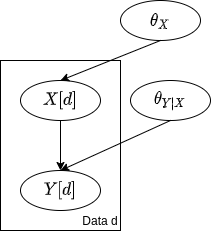

In [73]:
Image("figures/iid_bn.png")

Now, we have the parameters $\theta_X$ and $\theta_{Y|X}$, which we summarize in a single parameter set $\Theta$.

The likelihood function is (<font color = red>see in the whiteboard</font>):

$$
\begin{align}
\mathcal{L}(\Theta : \mathcal{D}) & = \prod_{d=1}^{M} P(x[d], y[d] | \Theta) \\
                                  & = \prod_{d=1}^{M} P(x[d] | \Theta) P(y[d] | x[d], \Theta) \\
                                  & = \left(\prod_{d=1}^{M} P(x[d] | \Theta)\right) \left(\prod_{d=1}^{M} P(y[d] | x[d], \Theta)\right) \\
                                  & = \underbrace{\left(\prod_{d=1}^{M} P(x[d] | \theta_X)\right)}_{\text{local likelihood}} \underbrace{\left(\prod_{d=1}^{M} P(y[d] | x[d], \theta_{Y|X})\right)}_{\text{local likelihood}}
\end{align}
$$

This can be generalized:

$$
\begin{align}
\mathcal{L}(\Theta : \mathcal{D}) & = \prod_{d=1}^{M} P(\bar{x}[d] | \Theta) \\
                                  & = \prod_{d=1}^{M} \prod_{i=1}^{n} P(x_i[d] | \mathrm{Pa}x_i[d], \Theta)  \\
                                  & = \prod_{i=1}^{n} \underbrace{\prod_{d=1}^{M} P(x_i[d] | \mathrm{Pa}x_i[d], \theta_{X_i|\mathrm{Pa}X_i})}_{\text{local likelihood } \mathcal{L}_i(\theta_{X_i|\mathrm{Pa}X_i} : \mathcal{D})}  \\
                                  & = \prod_{i=1}^{n} \mathcal{L}_i(\theta_{X_i|\mathrm{Pa}X_i} : \mathcal{D})
\end{align}
$$

Thus, if the parameters $\theta_{X_i|\mathrm{Pa}X_i}$ are disjoint, then the MLE can be computed by maximizing each local likelihood separately :).

### MLE for table CPDs

Using the above, the local likelihood ($\bar{U}=\mathrm{Pa}X$, <font color = red>see in the whiteboard</font>)

$$
\begin{align}
\prod_{d=1}^{M} P(x[d] | \bar{u}[d], \theta_{X|\bar{U}}) & = \prod_{x \in \mathrm{Val}(X),\bar{u} \in \mathrm{Val}(U)} \prod_{d: x[d]=x, \bar{u}[d]=\bar{u}} \underbrace{P(x[d] | \bar{u}[d], \theta_{X|\bar{U}})}_{\theta_{x|\bar{u}}} \\
& = \prod_{x \in \mathrm{Val}(X),\bar{u} \in \mathrm{Val}(U)} \theta_{x | \bar{u}}^{M(x,\bar{u})},
\end{align}
$$

where $M(x,\bar{u})$ is the number of times that the sample is consistent with $x, \bar{u}$.

Applying the same principle as in mutinomial distributions:

$$\hat{\theta}_{x|\bar{u}} = \frac{M(x,\bar{u})}{\sum_{x'} M(x',\bar{u})} = \frac{M(x,\bar{u})}{M(\bar{u})},$$

the MLE estimate corresponds to the count of data instances consistent with $x,\bar{u}$ over the count of data instances consistent with $\bar{u}$.

### How is this done in `pgmpy`?

Consider the simple model $$X \to Y:$$

In [74]:
# Import pgmpy.models.BayesianModel
from pgmpy.models import BayesianModel
# Import pgmpy.estimators.MaximumLikelihoodEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator

In [75]:
# Import pandas
import pandas as pd

In [76]:
help(np.random.randint)

Help on built-in function randint:

randint(...) method of numpy.random.mtrand.RandomState instance
    randint(low, high=None, size=None, dtype='l')
    
    Return random integers from `low` (inclusive) to `high` (exclusive).
    
    Return random integers from the "discrete uniform" distribution of
    the specified dtype in the "half-open" interval [`low`, `high`). If
    `high` is None (the default), then results are from [0, `low`).
    
    .. note::
        New code should use the ``integers`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    Parameters
    ----------
    low : int or array-like of ints
        Lowest (signed) integers to be drawn from the distribution (unless
        ``high=None``, in which case this parameter is one above the
        *highest* such integer).
    high : int or array-like of ints, optional
        If provided, one above the largest (signed) integer to be drawn
        from the distribution (see above fo

In [159]:
# Generate some random data for X -> Y
M = 10
data = np.random.randint(low=0, high=2, size=(M, 2))
#data = np.array([[0, 0],
#                 [0, 1],
#                 [0, 0],
#                 [1, 0],
#                 [1, 1]])

In [160]:
# Wrap data in a dataframe
data = pd.DataFrame(data=data, columns=['X', 'Y'])
data

,X,Y
0,1,0
1,1,0
2,0,1
3,0,0
4,0,0
5,1,0
6,0,0
7,0,0
8,1,1
9,1,1


In [161]:
# Instantiate model
model = BayesianModel([('X', 'Y')])

In [162]:
# Fit using MLE
model.fit(data=data, estimator=MaximumLikelihoodEstimator)

In [163]:
# Show CPDs
print(model.get_cpds('X'))

+------+-----+
| X(0) | 0.5 |
+------+-----+
| X(1) | 0.5 |
+------+-----+


In [164]:
print(model.get_cpds('Y'))

+------+------+------+
| X    | X(0) | X(1) |
+------+------+------+
| Y(0) | 0.8  | 0.6  |
+------+------+------+
| Y(1) | 0.2  | 0.4  |
+------+------+------+


### Fragmentation and overfitting

We have that

$$\hat{\theta}_{x|\bar{u}} = \frac{M(x,\bar{u})}{\sum_{x'} M(x',\bar{u})} = \frac{M(x,\bar{u})}{M(\bar{u})}.$$

- Note that the number of possible joint assignments $x, \bar{u}$ grows exponentially with the size of $|\bar{U}|$.

- This is, if $X$ has a lot of parents there will be few instances of $x, \bar{u}$.

- This will lead to very poor parameter estimates $\hat{\theta}_{x|\bar{u}}$

This phenomenon is called **fragmentation**.

Hence, when the amount of data is limited, we often obtan better generalization performances with simpler structures, **even when wrong**.

___

# 3. Bayesian parameter estimation for BNs

We motivate the study of **Bayesian estimation** with a remarkable limitation of MLE:

- Assume a coin is tossed 10 times, and it comes out $x^1$ 7 out of the the 10 tosses.

  $$\hat{\theta}_{MLE} = 0.7$$

- Assume a coin is tossed 10000 times, and it comes out $x^1$ 7000 out of the the 10000 tosses.

  $$\hat{\theta}_{MLE} = 0.7$$

The MLE in the second scenario is much more plausible than the MLE in the first one.

However, the MLE has not the ability to distinguish between these scenarios.

## 3.1. Bayesian estimation

Let's revisit the simple parameter estimation example:

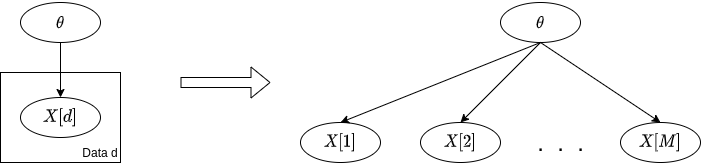

In [106]:
Image("figures/iid.png")

**Bayesian paradigm:** If we are uncertain about something, then we should view it as a Random Variable over which we have a distribution that is updated over time as more data is acquired.

Under this paradigm, the parameter $\theta$ will be a Random Variable itself.

- Given a fixed $\theta$, the tosses are independent.

- If $\theta$ is not known, then tosses are not marginally independent:
  - Each toss tells us something about $\theta$.

Joint probability model:

$$
\begin{align}
P(x[1], \dots, x[M], \theta) & = P(x[1], \dots, x[M] | \theta) P(\theta) \\
                             & = P(\theta) \underbrace{\prod_{d=1}^{M} P(x[d] | \theta)}_{\text{likelihood function}} \\
                             & = P(\theta) \theta^{M_1} (1 - \theta)^{M_0}.
\end{align}
$$

Hence, the posterior:

$$
\begin{align}
P(\theta | x[1], \dots, x[M]) & = \frac{P(x[1], \dots, x[M] | \theta) P(\theta)}{P(x[1], \dots, x[M])} \\
                              & \propto P(x[1], \dots, x[M] | \theta) P(\theta) \\
                              & = \theta^{M_1} (1 - \theta)^{M_0} P(\theta)
\end{align}
$$

- $P(x[1], \dots, x[M] | \theta)$ is the likelihood function, which we already know.

- $P(\theta)$ is the **prior distribution**.

- $P(x[1], \dots, x[M])$ is a normalizing constant with respect to $\theta$.

### Prior: Dirichlet distribution

If $X$ is a multinomial distribution over $k$ values, then a good assumption for the distribution of the parameters $\bar{\theta} = [\theta_1, \dots, \theta_k]$ is the [**Dirichlet distribution**](https://en.wikipedia.org/wiki/Dirichlet_distribution).

$\bar{\theta} \sim \mathrm{Dir}(\bar{\alpha})$, where $\bar{\alpha}=[\alpha_1, \dots, \alpha_k]$,  if

$$P(\bar{\theta}; \bar{\alpha}) = \frac{1}{Z} \prod_{i=1}^{k} \theta_i^{\alpha_i - 1},$$

where $\sum_{i=1}^{k}\theta_i=1$ and,

$$Z = \frac{\prod_{i=1}^{k} \Gamma(\alpha_i)}{\Gamma(\sum_{i=1}^{k}\alpha_i)},$$

where $\Gamma(x)= \int_{0}^{\infty}t^{x-1}e^{-t} \mathrm{d}t$ is the continuous extension of the factorial.

- Intuitively, the hyperparameters $\alpha_i$ correspond to the number of samples we have previously seen.

- The Dirichlet distribution is a multivariate generalization of the Beta distribution.

In [107]:
# Special function gamma
from scipy.special import gamma

In [109]:
# Beta distribution
def p_beta(theta, alpha1=1, alpha0=1):
    g = gamma(alpha1 + alpha0) / (gamma(alpha1) * gamma(alpha0))
    return g * theta**(alpha1 - 1) * (1 - theta)**(alpha0 - 1)

In [110]:
# Plot the beta distribution for different values of alpha1 and alpha0
theta = np.linspace(0, 1, 101)
beta_05 = p_beta(theta, 0.5, 0.5)
beta_1 = p_beta(theta, 1, 1)
beta_5 = p_beta(theta, 5, 5)
beta_10 = p_beta(theta, 10, 10)

/home/esteban/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


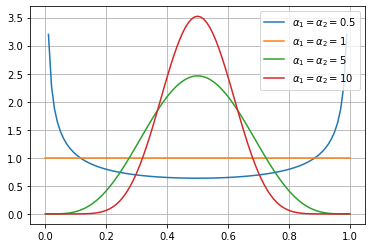

In [112]:
plt.figure(figsize=(6, 4))
plt.plot(theta, beta_05, label=r'$\alpha_1=\alpha_2=0.5$')
plt.plot(theta, beta_1, label=r'$\alpha_1=\alpha_2=1$')
plt.plot(theta, beta_5, label=r'$\alpha_1=\alpha_2=5$')
plt.plot(theta, beta_10, label=r'$\alpha_1=\alpha_2=10$')
plt.grid()
plt.legend(loc='best')

#### Now, having this Dirichlet prior, how is the posterior?

Assume that $X$ is multinomial.

We have that:

$$
P(\bar{\theta} | \mathcal{D}) \propto P(\mathcal{D} | \bar{\theta}) P(\bar{\theta})
$$

- The likelihood function is: $P(\mathcal{D} | \bar{\theta}) = \prod_{i=1}^{k} \theta_i^{M_i}$.

- The prior is: $P(\bar{\theta}) \propto \prod_{i=1}^{k} \theta_i^{\alpha_i - 1}$

Then,

$$
P(\bar{\theta} | \mathcal{D}) \propto \prod_{i=1}^{k} \theta_i^{\alpha_i + M_i - 1}.
$$

This is, the posterior also Dirichlet: $(\bar{\theta} | \mathcal{D}) \sim \mathrm{Dir}(\alpha_1 + M_1, \dots, \alpha_k + M_k)$.

### In this sense ...

Before seeing data instances:

$$P(X=x^i | \theta) = \frac{\alpha_i}{\sum_{j=1}^{k}\alpha_j} = \frac{\alpha_i}{\alpha}.$$

After seeing data instances:

$$P(X[M+1]=x^i | \theta, x[1], \dots, x[M]) = \frac{\alpha_i + M_i}{\alpha + M}.$$


- The term $\alpha=\sum_{j=1}^{k}\alpha_j$ is known as **equivalent sample size**.
  - Larger $\alpha$ means that we are more confident in our prior.

### What is the effect?

In [142]:
# Generate random numbers form a Bernoulli distribution
M = 10000
theta = 0.7
data = np.random.choice([0, 1], p=[1 - theta, theta], size=M)

In [143]:
# Obtain MLE estimation at each step
theta_MLE = (data == 1).cumsum() / np.arange(1, M + 1)

In [144]:
# Obtain Bayesian estimation for different values of alpha
# alpha1 = alpha2 = alpha_i
# Equivalent sample size alpha = alpha1 + alpha2 = 2 * alpha_i
alpha_is = [1, 5, 10, 100]
theta_BE = np.zeros((len(alpha_is), M))
for i, alpha_i in enumerate(alpha_is):
    theta_BE[i, :] = ((data == 1).cumsum() + alpha_i)  / (np.arange(1, M + 1) + 2 * alpha_i)

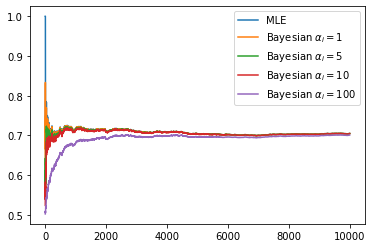

In [145]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot(theta_MLE, label='MLE')
for i, alpha_i in enumerate(alpha_is):
    plt.plot(theta_BE[i, :], label=r'Bayesian $\alpha_i=${}'.format(alpha_i))
plt.legend(loc='best')

- Bayesian estimates are less sensitive to noise in the data.

- Bayesian estimates $\to$ MLE as number of samples $\to \infty$.

The ideas in BNs are very similar. Please, take a look after Chapter 17.

### How is this done in `pgmpy`?

Consider the simple model $$X \to Y:$$

In [146]:
# Import pgmpy.estimators.BayesianEstimator
from pgmpy.estimators import BayesianEstimator

In [147]:
help(BayesianEstimator)

Help on class BayesianEstimator in module pgmpy.estimators.BayesianEstimator:

class BayesianEstimator(pgmpy.estimators.base.ParameterEstimator)
 |  BayesianEstimator(model, data, **kwargs)
 |  
 |  Method resolution order:
 |      BayesianEstimator
 |      pgmpy.estimators.base.ParameterEstimator
 |      pgmpy.estimators.base.BaseEstimator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model, data, **kwargs)
 |      Class used to compute parameters for a model using Bayesian Parameter Estimation.
 |      See `MaximumLikelihoodEstimator` for constructor parameters.
 |  
 |  estimate_cpd(self, node, prior_type='BDeu', pseudo_counts=[], equivalent_sample_size=5)
 |      Method to estimate the CPD for a given variable.
 |      
 |      Parameters
 |      ----------
 |      node: int, string (any hashable python object)
 |          The name of the variable for which the CPD is to be estimated.
 |      
 |      prior_type: 'dirichlet', 'BDeu', 'K2',
 |       

In [167]:
# Instantiate estimator
estimator = BayesianEstimator(model=model,
                              data=data)

In [172]:
# Fit CPD of X
print(estimator.estimate_cpd('X',
                             prior_type='dirichlet',
                             pseudo_counts=[[1], [1]]))

+------+-----+
| X(0) | 0.5 |
+------+-----+
| X(1) | 0.5 |
+------+-----+


In [173]:
# Fit CPD of Y
print(estimator.estimate_cpd('Y',
                             prior_type='dirichlet',
                             pseudo_counts=[[1, 1], [1, 1]]))

+------+--------------------+---------------------+
| X    | X(0)               | X(1)                |
+------+--------------------+---------------------+
| Y(0) | 0.7142857142857143 | 0.5714285714285714  |
+------+--------------------+---------------------+
| Y(1) | 0.2857142857142857 | 0.42857142857142855 |
+------+--------------------+---------------------+


# Announcements

## 1. Exam of the second module the next class.

## 2. Quiz of this class on November 10th.

## 3. Homework 6 (last one :D) due on November 9th.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>